In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from tqdm import tqdm_notebook
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns



plt.style.use('seaborn')
sns.set(font_scale=1)

import gc

In [62]:
train = pd.read_csv("../input/landslide-prevention-and-innovation-challenge/Train (12).csv")
test = pd.read_csv("../input/landslide-prevention-and-innovation-challenge/Test (13).csv")
sample = pd.read_csv('../input/landslide-prevention-and-innovation-challenge/SampleSubmission (7).csv')

In [63]:
train

,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,...,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif,Label
0,1,130,129,127,126,123,126,125,124,122,...,1.281779,1.281743,1.281720,1.281684,1.281811,1.281788,1.281752,1.281729,1.281693,0
1,2,161,158,155,153,151,162,159,155,153,...,1.359639,1.359608,1.359587,1.359556,1.359683,1.359662,1.359631,1.359610,1.359579,1
2,3,149,151,154,156,158,154,157,158,160,...,1.365005,1.365025,1.365055,1.365075,1.364937,1.364967,1.364988,1.365018,1.365038,0
3,4,80,78,77,75,73,80,78,77,75,...,1.100708,1.100738,1.100759,1.100789,1.100630,1.100650,1.100680,1.100700,1.100731,0
4,5,117,115,114,112,110,115,113,111,110,...,1.284180,1.284130,1.284056,1.284006,1.284125,1.284050,1.284001,1.283926,1.283876,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,10860,203,202,201,200,199,202,201,201,199,...,1.271912,1.272011,1.272076,1.272174,1.271720,1.271786,1.271884,1.271950,1.272048,0
10860,10861,432,430,427,423,421,431,429,426,422,...,1.331153,1.331137,1.331113,1.331096,1.331207,1.331183,1.331167,1.331142,1.331126,1
10861,10862,348,345,342,339,335,344,342,339,336,...,1.298362,1.298337,1.298321,1.298297,1.298392,1.298376,1.298352,1.298336,1.298311,1
10862,10863,93,91,90,88,86,96,94,93,92,...,1.355035,1.355061,1.355099,1.355125,1.354937,1.354976,1.355002,1.355041,1.355067,0


In [64]:
id_=test["Sample_ID"]
test.drop("Sample_ID", axis=1, inplace=True)
train.drop("Sample_ID", axis=1, inplace=True)

In [65]:
col=train.columns[:-1]

In [66]:
col

Index(['1_elevation', '2_elevation', '3_elevation', '4_elevation',
       '5_elevation', '6_elevation', '7_elevation', '8_elevation',
       '9_elevation', '10_elevation',
       ...
       '16_sdoif', '17_sdoif', '18_sdoif', '19_sdoif', '20_sdoif', '21_sdoif',
       '22_sdoif', '23_sdoif', '24_sdoif', '25_sdoif'],
      dtype='object', length=225)

In [67]:
# train["elevation_mean"]=train[train.columns[:25].to_list()].mean(axis=1)
# train["slope_mean"]=train[train.columns[25:50].to_list()].mean(axis=1)
# train["aspect_mean"]=train[train.columns[50:75].to_list()].mean(axis=1)
# train["placurv_mean"]=train[train.columns[75:100].to_list()].mean(axis=1)
# train["procurv_mean"]=train[train.columns[100:125].to_list()].mean(axis=1)
# train["lsfactor_mean"]=train[train.columns[125:150].to_list()].mean(axis=1)
# train["twi_mean"]=train[train.columns[150:175].to_list()].mean(axis=1)
# train["geology_mean"]=train[train.columns[175:200].to_list()].mean(axis=1)
# train["sdoif_mean"]=train[train.columns[200:225].to_list()].mean(axis=1)
# ########################################################################
# train["elevation_count"]=train[train.columns[:25].to_list()].count(axis=1)
# train["slope_count"]=train[train.columns[25:50].to_list()].count(axis=1)
# train["aspect_count"]=train[train.columns[50:75].to_list()].count(axis=1)
# train["placurv_count"]=train[train.columns[75:100].to_list()].count(axis=1)
# train["procurv_count"]=train[train.columns[100:125].to_list()].count(axis=1)
# train["lsfactor_count"]=train[train.columns[125:150].to_list()].count(axis=1)
# train["twi_count"]=train[train.columns[150:175].to_list()].count(axis=1)
# train["geology_count"]=train[train.columns[175:200].to_list()].count(axis=1)
# train["sdoif_count"]=train[train.columns[200:225].to_list()].count(axis=1)
# #########################################################################
# train["elevation_std"]=train[train.columns[:25].to_list()].std(axis=1)
# train["slope_std"]=train[train.columns[25:50].to_list()].std(axis=1)
# train["aspect_std"]=train[train.columns[50:75].to_list()].std(axis=1)
# train["placurv_std"]=train[train.columns[75:100].to_list()].std(axis=1)
# train["procurv_std"]=train[train.columns[100:125].to_list()].std(axis=1)
# train["lsfactor_std"]=train[train.columns[125:150].to_list()].std(axis=1)
# train["twi_std"]=train[train.columns[150:175].to_list()].std(axis=1)
# train["geology_std"]=train[train.columns[175:200].to_list()].std(axis=1)
# train["sdoif_std"]=train[train.columns[200:225].to_list()].std(axis=1)
# #########################################################################
# train["elevation_min"]=train[train.columns[:25].to_list()].min(axis=1)
# train["slope_min"]=train[train.columns[25:50].to_list()].min(axis=1)
# train["aspect_min"]=train[train.columns[50:75].to_list()].min(axis=1)
# train["placurv_min"]=train[train.columns[75:100].to_list()].min(axis=1)
# train["procurv_min"]=train[train.columns[100:125].to_list()].min(axis=1)
# train["lsfactor_min"]=train[train.columns[125:150].to_list()].min(axis=1)
# train["twi_min"]=train[train.columns[150:175].to_list()].min(axis=1)
# train["geology_min"]=train[train.columns[175:200].to_list()].min(axis=1)
# train["sdoif_min"]=train[train.columns[200:225].to_list()].min(axis=1)
# #########################################################################
# train["elevation_max"]=train[train.columns[:25].to_list()].max(axis=1)
# train["slope_max"]=train[train.columns[25:50].to_list()].max(axis=1)
# train["aspect_max"]=train[train.columns[50:75].to_list()].max(axis=1)
# train["placurv_max"]=train[train.columns[75:100].to_list()].max(axis=1)
# train["procurv_max"]=train[train.columns[100:125].to_list()].max(axis=1)
# train["lsfactor_max"]=train[train.columns[125:150].to_list()].max(axis=1)
# train["twi_max"]=train[train.columns[150:175].to_list()].max(axis=1)
# train["geology_max"]=train[train.columns[175:200].to_list()].max(axis=1)
# train["sdoif_max"]=train[train.columns[200:225].to_list()].max(axis=1)
# #########################################################################
# train["elevation_kurt"]=train[train.columns[:25].to_list()].kurt(axis=1)
# train["slope_kurt"]=train[train.columns[25:50].to_list()].kurt(axis=1)
# train["aspect_kurt"]=train[train.columns[50:75].to_list()].kurt(axis=1)
# train["placurv_kurt"]=train[train.columns[75:100].to_list()].kurt(axis=1)
# train["procurv_kurt"]=train[train.columns[100:125].to_list()].kurt(axis=1)
# train["lsfactor_kurt"]=train[train.columns[125:150].to_list()].kurt(axis=1)
# train["twi_kurt"]=train[train.columns[150:175].to_list()].kurt(axis=1)
# train["geology_kurt"]=train[train.columns[175:200].to_list()].kurt(axis=1)
# train["sdoif_kurt"]=train[train.columns[200:225].to_list()].kurt(axis=1)
# #########################################################################
# train["elevation_skew"]=train[train.columns[:25].to_list()].skew(axis=1)
# train["slope_skew"]=train[train.columns[25:50].to_list()].skew(axis=1)
# train["aspect_skew"]=train[train.columns[50:75].to_list()].skew(axis=1)
# train["placurv_skew"]=train[train.columns[75:100].to_list()].skew(axis=1)
# train["procurv_skew"]=train[train.columns[100:125].to_list()].skew(axis=1)
# train["lsfactor_skew"]=train[train.columns[125:150].to_list()].skew(axis=1)
# train["twi_skew"]=train[train.columns[150:175].to_list()].skew(axis=1)
# train["geology_skew"]=train[train.columns[175:200].to_list()].skew(axis=1)
# train["sdoif_skew"]=train[train.columns[200:225].to_list()].skew(axis=1)
# #########################################################################
# train["elevation_q7.5"]=train[train.columns[:25].to_list()].quantile(q=0.75,axis=1)
# train["slope_q7.5"]=train[train.columns[25:50].to_list()].quantile(q=0.75,axis=1)
# train["aspect_q7.5"]=train[train.columns[50:75].to_list()].quantile(q=0.75,axis=1)
# train["placurv_q7.5"]=train[train.columns[75:100].to_list()].quantile(q=0.75,axis=1)
# train["procurv_q7.5"]=train[train.columns[100:125].to_list()].quantile(q=0.75,axis=1)
# train["lsfactor_q7.5"]=train[train.columns[125:150].to_list()].quantile(q=0.75,axis=1)
# train["twi_q7.5"]=train[train.columns[150:175].to_list()].quantile(q=0.75,axis=1)
# train["geology_q7.5"]=train[train.columns[175:200].to_list()].quantile(q=0.75,axis=1)
# train["sdoif_q7.5"]=train[train.columns[200:225].to_list()].quantile(q=0.75,axis=1)
# #########################################################################
# train["elevation_q5"]=train[train.columns[:25].to_list()].quantile(q=0.5,axis=1)
# train["slope_q5"]=train[train.columns[25:50].to_list()].quantile(q=0.5,axis=1)
# train["aspect_q5"]=train[train.columns[50:75].to_list()].quantile(q=0.5,axis=1)
# train["placurv_q5"]=train[train.columns[75:100].to_list()].quantile(q=0.5,axis=1)
# train["procurv_q5"]=train[train.columns[100:125].to_list()].quantile(q=0.5,axis=1)
# train["lsfactor_q5"]=train[train.columns[125:150].to_list()].quantile(q=0.5,axis=1)
# train["twi_q5"]=train[train.columns[150:175].to_list()].quantile(q=0.5,axis=1)
# train["geology_q5"]=train[train.columns[175:200].to_list()].quantile(q=0.5,axis=1)
# train["sdoif_q5"]=train[train.columns[200:225].to_list()].quantile(q=0.5,axis=1)
# #########################################################################
# train["elevation_q2.5"]=train[train.columns[:25].to_list()].quantile(q=0.25,axis=1)
# train["slope_q2.5"]=train[train.columns[25:50].to_list()].quantile(q=0.25,axis=1)
# train["aspect_q2.5"]=train[train.columns[50:75].to_list()].quantile(q=0.25,axis=1)
# train["placurv_q2.5"]=train[train.columns[75:100].to_list()].quantile(q=0.25,axis=1)
# train["procurv_q2.5"]=train[train.columns[100:125].to_list()].quantile(q=0.25,axis=1)
# train["lsfactor_q2.5"]=train[train.columns[125:150].to_list()].quantile(q=0.25,axis=1)
# train["twi_q2.5"]=train[train.columns[150:175].to_list()].quantile(q=0.25,axis=1)
# train["geology_q2.5"]=train[train.columns[175:200].to_list()].quantile(q=0.25,axis=1)
# train["sdoif_q2.5"]=train[train.columns[200:225].to_list()].quantile(q=0.25,axis=1)
# #########################################################################
# train.drop(col, axis=1, inplace=True)

In [68]:
# test["elevation_mean"]=test[test.columns[:25].to_list()].mean(axis=1)
# test["slope_mean"]=test[test.columns[25:50].to_list()].mean(axis=1)
# test["aspect_mean"]=test[test.columns[50:75].to_list()].mean(axis=1)
# test["placurv_mean"]=test[test.columns[75:100].to_list()].mean(axis=1)
# test["procurv_mean"]=test[test.columns[100:125].to_list()].mean(axis=1)
# test["lsfactor_mean"]=test[test.columns[125:150].to_list()].mean(axis=1)
# test["twi_mean"]=test[test.columns[150:175].to_list()].mean(axis=1)
# test["geology_mean"]=test[test.columns[175:200].to_list()].mean(axis=1)
# test["sdoif_mean"]=test[test.columns[200:225].to_list()].mean(axis=1)
# ########################################################################
# test["elevation_count"]=test[test.columns[:25].to_list()].count(axis=1)
# test["slope_count"]=test[test.columns[25:50].to_list()].count(axis=1)
# test["aspect_count"]=test[test.columns[50:75].to_list()].count(axis=1)
# test["placurv_count"]=test[test.columns[75:100].to_list()].count(axis=1)
# test["procurv_count"]=test[test.columns[100:125].to_list()].count(axis=1)
# test["lsfactor_count"]=test[test.columns[125:150].to_list()].count(axis=1)
# test["twi_count"]=test[test.columns[150:175].to_list()].count(axis=1)
# test["geology_count"]=test[test.columns[175:200].to_list()].count(axis=1)
# test["sdoif_count"]=test[test.columns[200:225].to_list()].count(axis=1)
# #########################################################################
# test["elevation_std"]=test[test.columns[:25].to_list()].std(axis=1)
# test["slope_std"]=test[test.columns[25:50].to_list()].std(axis=1)
# test["aspect_std"]=test[test.columns[50:75].to_list()].std(axis=1)
# test["placurv_std"]=test[test.columns[75:100].to_list()].std(axis=1)
# test["procurv_std"]=test[test.columns[100:125].to_list()].std(axis=1)
# test["lsfactor_std"]=test[test.columns[125:150].to_list()].std(axis=1)
# test["twi_std"]=test[test.columns[150:175].to_list()].std(axis=1)
# test["geology_std"]=test[test.columns[175:200].to_list()].std(axis=1)
# test["sdoif_std"]=test[test.columns[200:225].to_list()].std(axis=1)
# #########################################################################
# test["elevation_min"]=test[test.columns[:25].to_list()].min(axis=1)
# test["slope_min"]=test[test.columns[25:50].to_list()].min(axis=1)
# test["aspect_min"]=test[test.columns[50:75].to_list()].min(axis=1)
# test["placurv_min"]=test[test.columns[75:100].to_list()].min(axis=1)
# test["procurv_min"]=test[test.columns[100:125].to_list()].min(axis=1)
# test["lsfactor_min"]=test[test.columns[125:150].to_list()].min(axis=1)
# test["twi_min"]=test[test.columns[150:175].to_list()].min(axis=1)
# test["geology_min"]=test[test.columns[175:200].to_list()].min(axis=1)
# test["sdoif_min"]=test[test.columns[200:225].to_list()].min(axis=1)
# #########################################################################
# test["elevation_max"]=test[test.columns[:25].to_list()].max(axis=1)
# test["slope_max"]=test[test.columns[25:50].to_list()].max(axis=1)
# test["aspect_max"]=test[test.columns[50:75].to_list()].max(axis=1)
# test["placurv_max"]=test[test.columns[75:100].to_list()].max(axis=1)
# test["procurv_max"]=test[test.columns[100:125].to_list()].max(axis=1)
# test["lsfactor_max"]=test[test.columns[125:150].to_list()].max(axis=1)
# test["twi_max"]=test[test.columns[150:175].to_list()].max(axis=1)
# test["geology_max"]=test[test.columns[175:200].to_list()].max(axis=1)
# test["sdoif_max"]=test[test.columns[200:225].to_list()].max(axis=1)
# #########################################################################
# test["elevation_kurt"]=test[test.columns[:25].to_list()].kurt(axis=1)
# test["slope_kurt"]=test[test.columns[25:50].to_list()].kurt(axis=1)
# test["aspect_kurt"]=test[test.columns[50:75].to_list()].kurt(axis=1)
# test["placurv_kurt"]=test[test.columns[75:100].to_list()].kurt(axis=1)
# test["procurv_kurt"]=test[test.columns[100:125].to_list()].kurt(axis=1)
# test["lsfactor_kurt"]=test[test.columns[125:150].to_list()].kurt(axis=1)
# test["twi_kurt"]=test[test.columns[150:175].to_list()].kurt(axis=1)
# test["geology_kurt"]=test[test.columns[175:200].to_list()].kurt(axis=1)
# test["sdoif_kurt"]=test[test.columns[200:225].to_list()].kurt(axis=1)
# #########################################################################
# test["elevation_skew"]=test[test.columns[:25].to_list()].skew(axis=1)
# test["slope_skew"]=test[test.columns[25:50].to_list()].skew(axis=1)
# test["aspect_skew"]=test[test.columns[50:75].to_list()].skew(axis=1)
# test["placurv_skew"]=test[test.columns[75:100].to_list()].skew(axis=1)
# test["procurv_skew"]=test[test.columns[100:125].to_list()].skew(axis=1)
# test["lsfactor_skew"]=test[test.columns[125:150].to_list()].skew(axis=1)
# test["twi_skew"]=test[test.columns[150:175].to_list()].skew(axis=1)
# test["geology_skew"]=test[test.columns[175:200].to_list()].skew(axis=1)
# test["sdoif_skew"]=test[test.columns[200:225].to_list()].skew(axis=1)
# #########################################################################
# test["elevation_q7.5"]=test[test.columns[:25].to_list()].quantile(q=0.75,axis=1)
# test["slope_q7.5"]=test[test.columns[25:50].to_list()].quantile(q=0.75,axis=1)
# test["aspect_q7.5"]=test[test.columns[50:75].to_list()].quantile(q=0.75,axis=1)
# test["placurv_q7.5"]=test[test.columns[75:100].to_list()].quantile(q=0.75,axis=1)
# test["procurv_q7.5"]=test[test.columns[100:125].to_list()].quantile(q=0.75,axis=1)
# test["lsfactor_q7.5"]=test[test.columns[125:150].to_list()].quantile(q=0.75,axis=1)
# test["twi_q7.5"]=test[test.columns[150:175].to_list()].quantile(q=0.75,axis=1)
# test["geology_q7.5"]=test[test.columns[175:200].to_list()].quantile(q=0.75,axis=1)
# test["sdoif_q7.5"]=test[test.columns[200:225].to_list()].quantile(q=0.75,axis=1)
# #########################################################################
# test["elevation_q5"]=test[test.columns[:25].to_list()].quantile(q=0.5,axis=1)
# test["slope_q5"]=test[test.columns[25:50].to_list()].quantile(q=0.5,axis=1)
# test["aspect_q5"]=test[test.columns[50:75].to_list()].quantile(q=0.5,axis=1)
# test["placurv_q5"]=test[test.columns[75:100].to_list()].quantile(q=0.5,axis=1)
# test["procurv_q5"]=test[test.columns[100:125].to_list()].quantile(q=0.5,axis=1)
# test["lsfactor_q5"]=test[test.columns[125:150].to_list()].quantile(q=0.5,axis=1)
# test["twi_q5"]=test[test.columns[150:175].to_list()].quantile(q=0.5,axis=1)
# test["geology_q5"]=test[test.columns[175:200].to_list()].quantile(q=0.5,axis=1)
# test["sdoif_q5"]=test[test.columns[200:225].to_list()].quantile(q=0.5,axis=1)
# #########################################################################
# test["elevation_q2.5"]=test[test.columns[:25].to_list()].quantile(q=0.25,axis=1)
# test["slope_q2.5"]=test[test.columns[25:50].to_list()].quantile(q=0.25,axis=1)
# test["aspect_q2.5"]=test[test.columns[50:75].to_list()].quantile(q=0.25,axis=1)
# test["placurv_q2.5"]=test[test.columns[75:100].to_list()].quantile(q=0.25,axis=1)
# test["procurv_q2.5"]=test[test.columns[100:125].to_list()].quantile(q=0.25,axis=1)
# test["lsfactor_q2.5"]=test[test.columns[125:150].to_list()].quantile(q=0.25,axis=1)
# test["twi_q2.5"]=test[test.columns[150:175].to_list()].quantile(q=0.25,axis=1)
# test["geology_q2.5"]=test[test.columns[175:200].to_list()].quantile(q=0.25,axis=1)
# test["sdoif_q2.5"]=test[test.columns[200:225].to_list()].quantile(q=0.25,axis=1)
# #########################################################################
# test.drop(col, axis=1, inplace=True)

In [69]:
train

,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,...,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif,Label
0,130,129,127,126,123,126,125,124,122,119,...,1.281779,1.281743,1.281720,1.281684,1.281811,1.281788,1.281752,1.281729,1.281693,0
1,161,158,155,153,151,162,159,155,153,151,...,1.359639,1.359608,1.359587,1.359556,1.359683,1.359662,1.359631,1.359610,1.359579,1
2,149,151,154,156,158,154,157,158,160,161,...,1.365005,1.365025,1.365055,1.365075,1.364937,1.364967,1.364988,1.365018,1.365038,0
3,80,78,77,75,73,80,78,77,75,73,...,1.100708,1.100738,1.100759,1.100789,1.100630,1.100650,1.100680,1.100700,1.100731,0
4,117,115,114,112,110,115,113,111,110,108,...,1.284180,1.284130,1.284056,1.284006,1.284125,1.284050,1.284001,1.283926,1.283876,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,203,202,201,200,199,202,201,201,199,198,...,1.271912,1.272011,1.272076,1.272174,1.271720,1.271786,1.271884,1.271950,1.272048,0
10860,432,430,427,423,421,431,429,426,422,419,...,1.331153,1.331137,1.331113,1.331096,1.331207,1.331183,1.331167,1.331142,1.331126,1
10861,348,345,342,339,335,344,342,339,336,332,...,1.298362,1.298337,1.298321,1.298297,1.298392,1.298376,1.298352,1.298336,1.298311,1
10862,93,91,90,88,86,96,94,93,92,91,...,1.355035,1.355061,1.355099,1.355125,1.354937,1.354976,1.355002,1.355041,1.355067,0


In [70]:
y_train = train[['Label']]
df_train=train.drop(['Label'], axis=1)
cols=df_train.columns

**without scaling 0.74 with scaling 0.73**

In [71]:
from sklearn.decomposition import PCA
pca = PCA()
df_train = pca.fit_transform(df_train)
test = pca.transform(test)

In [72]:
test.shape

(5430, 225)

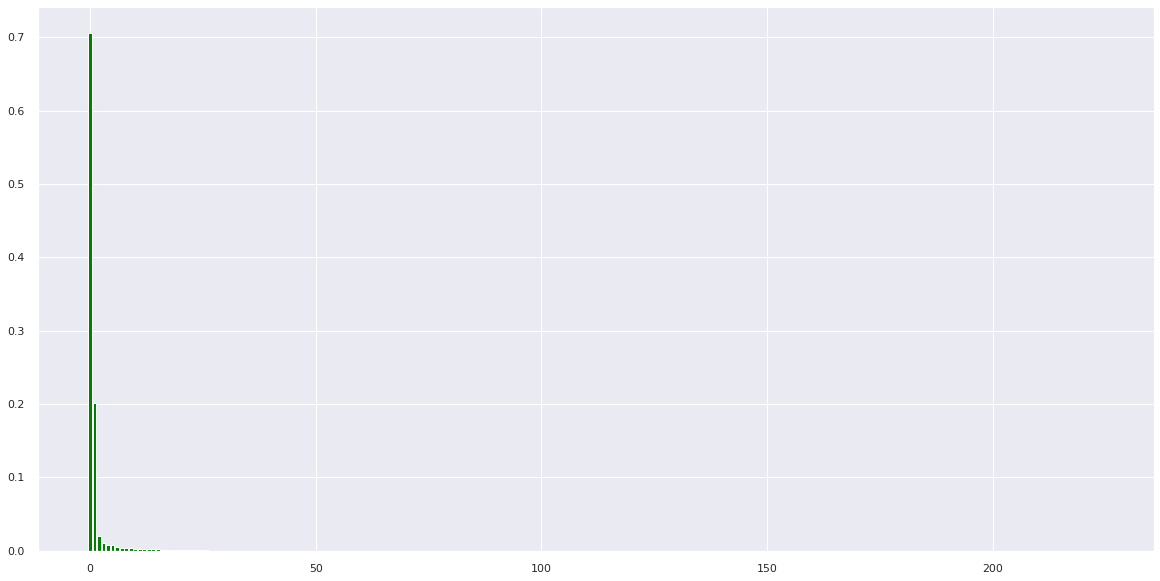

In [73]:
plt.figure(figsize=(20,10))
plt.bar(x=range(225), height=pca.explained_variance_ratio_, color="green")
plt.show()

In [74]:
df_train = df_train[:, :15]
test = test[:, :15]

In [75]:
df_train.shape

(10864, 15)

In [76]:
df_train = pd.DataFrame(df_train, columns=train.columns[:15])
test = pd.DataFrame(test, columns=train.columns[:15])

In [77]:
test

,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,11_elevation,12_elevation,13_elevation,14_elevation,15_elevation
0,-539.481556,-411.852735,-36.158875,-55.208468,68.695324,17.720398,73.939028,-92.950221,-85.278400,-44.371074,85.038135,25.872979,-45.166795,86.610343,-35.709950
1,-201.841244,172.445034,116.974039,65.530475,-55.798454,1.555493,20.637882,11.820348,-3.986176,-29.305507,18.397011,10.354779,-6.282558,-5.731303,0.776015
2,-935.191997,663.622594,5.258780,214.031588,7.504022,-2.729107,-40.540802,-72.276820,-61.953898,28.325939,17.126529,26.687942,-28.823984,-23.156184,7.123231
3,-462.399995,679.704290,-30.057512,30.976647,-17.708701,16.577638,4.677245,-4.860178,-6.230394,-26.866410,-19.854619,-9.160691,-5.986809,9.976915,-10.225007
4,539.702754,498.990198,-2.937176,39.746682,-7.059820,17.653339,-2.253213,6.612117,1.880320,-8.052746,-1.763888,-8.531312,0.954258,-1.550202,-9.374032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5425,-978.012091,658.613673,45.194486,-46.893127,-18.929838,48.683276,-24.378595,10.063697,18.460811,14.930701,-11.061115,-8.848305,-2.258612,-3.712835,-0.663594
5426,-381.704168,-316.511541,23.142154,-93.302888,18.447728,2.779491,-0.136575,-1.815770,4.094604,26.717233,5.837065,0.061591,3.144929,3.335465,1.985171
5427,-230.894425,-515.078514,-1.444705,-65.692072,10.563735,-24.653152,11.829853,15.401713,15.504942,-4.586970,-2.746398,8.209619,4.622302,-9.539180,-4.700691
5428,-390.136875,666.356716,12.453948,-11.383789,-14.035941,-4.969259,3.376127,23.299737,14.717495,-6.021645,-2.735511,2.420803,0.642280,-4.177945,0.990714


In [78]:
cols=test.columns

In [79]:
cols

Index(['1_elevation', '2_elevation', '3_elevation', '4_elevation',
       '5_elevation', '6_elevation', '7_elevation', '8_elevation',
       '9_elevation', '10_elevation', '11_elevation', '12_elevation',
       '13_elevation', '14_elevation', '15_elevation'],
      dtype='object')

In [80]:
from sklearn.preprocessing import RobustScaler
ss = RobustScaler()
df_train = pd.DataFrame(ss.fit_transform(df_train), columns=df_train.columns)
test = pd.DataFrame(ss.transform(test), columns=test.columns)

In [81]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold,StratifiedKFold ,GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn import  ensemble
def get_model(Name='lgbm') :
    if Name=='lgbm' :
      return LGBMClassifier(**{ 'boosting_type': 'gbdt','objective': 'binary','metric': 'auc',
                                'n_estimators': 500,'colsample_bytree' : 0.8,
                                'seed': 42,'silent':False,
                                'early_stopping_rounds': 100,
                                'learning_rate' : 0.05,'num_iterations': 1500,
                                'max_depth' :8 ,'num_leaves' : 150,
                                'max_bins': 85,'min_data_in_leaf':30 })
test_ = test[cols]
Model_Name = "lgbm"
folds = StratifiedKFold(n_splits=15, shuffle=True, random_state=5168)
oofs  = np.zeros((len(df_train[cols])))
test_predictions = np.zeros((len(test)))
tst_predd = np.zeros((len(test)))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, train['Label'])):
    X_train, y_train = df_train.iloc[trn_idx][cols], train.iloc[trn_idx]['Label']
    X_valid, y_valid = df_train.iloc[val_idx][cols], train.iloc[val_idx]['Label']
#     X_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
#     X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    clf = get_model(Name=Model_Name)
    clf.fit(X_train, y_train, eval_set = [(X_valid, y_valid)],
            verbose =100, early_stopping_rounds = 500)
    
    vp = clf.predict(X_valid)
    oofs[val_idx] = vp
    val_score = mean_squared_error((vp), (y_valid),squared=True)
    print(4*'-- -- -- --')
    print(f'Fold {fold_+1} Val score: {val_score}')
    print(4*'-- -- -- --')
    
    tp = clf.predict(test_)
    test_predictions += tp / folds.n_splits
    tst_predd += tp

  
print()
print(3*'###',10*"^",3*'###')
print(mean_squared_error(train["Label"], oofs,squared=True))
print("Model training")
# clf.fit(X_train, y_train )

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=500
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 2535, number of negative: 7604
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 10139, number of used features: 15
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=500

In [82]:
np.unique(test_predictions)

array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
       0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
       0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
       1.        ])

In [83]:
# len(test_predictions)

In [84]:
# cols=test.columns
# predict = clf.predict_proba(test[cols])

In [85]:
# predict

In [86]:
# l=[]
# for i in predict:
#     l.append(np.argmax(i))

In [87]:
for i in range(len(test_predictions)):
    if test_predictions[i]>=0.5:
        test_predictions[i]=1
    else:
        test_predictions[i]=0

In [88]:
sub=pd.DataFrame({"Sample_ID":id_,"Label":test_predictions})

In [89]:
sub

,Sample_ID,Label
0,10865,0.0
1,10866,0.0
2,10867,0.0
3,10868,1.0
4,10869,0.0
...,...,...
5425,16290,0.0
5426,16291,0.0
5427,16292,0.0
5428,16293,0.0


In [90]:
from IPython.display import FileLink
def create_submission(submission_file, submission_name):
    submission_file.to_csv(submission_name+".csv",index=False)
    return FileLink(submission_name+".csv")
create_submission(sub, "sol")

/kaggle/working/sol.csv

#### 